#S2024.2 – Redes Neurais e Deep Learning
**Objetivo**: Usar uma rede LSTM para prever o consumo mensal de energia elétrica
residencial no Brasil a partir de dados históricos.

Base de Dados: O conjunto de dados está no teams, com o nome
consumo_eletrico_brasil.csv  

Fonte de Dados: https://basedosdados.org/dataset/3e31e540-81ba-4665-9e72
3f81c176adad?table=b955feef-1649-428b-ba46-bc891d2facc2

##Contexto
A previsão do consumo de energia é essencial para ajudar no planejamento e uso
eficiente de recursos. O dataset que você recebeu contém dados mensais de consumo
residencial de energia no Brasil ao longo de vários anos. Sua tarefa é criar um modelo
de rede neural recorrente (LSTM) para prever o consumo dos próximos 12 meses com
base nesses dados históricos.


1. Tratamento dos dados

i. Considere apenas o tipo_consumo residencial.

ii. Agregue as informações dos estados considerando o consumo total e
número de consumidores (vide código anexo)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FIAP/Global Solution/gs2sem/Redes Neurais/consumo_eletrico_brasil.csv")


In [ ]:
df


,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
38875,2023,12,BA,Residencial,5932740.0,718461
38876,2023,12,PA,Residencial,2614106.0,478726
38877,2023,12,AC,Residencial,245699.0,58301
38878,2023,12,RN,Residencial,1390080.0,210119


In [ ]:
#Considere apenas o tipo_consumo residencial.
df = df[df['tipo_consumo'] == 'Residencial']


In [ ]:
df.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
1620,2004,1,RJ,Residencial,4900324.0,873761
1621,2004,1,MG,Residencial,5050859.0,628873
1622,2004,1,SP,Residencial,11535305.0,2074540
1623,2004,1,CE,Residencial,1724128.0,165168
1624,2004,1,ES,Residencial,811450.0,117209


In [ ]:
df['numero_consumidores'].isna().sum()

0

In [ ]:
df['data'] = pd.to_datetime(
    df[['ano', 'mes']].assign(DIA=1).rename(columns={'ano': 'year', 'mes': 'month', 'DIA': 'day'})
)


In [ ]:
df.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,data
1620,2004,1,RJ,Residencial,4900324.0,873761,2004-01-01
1621,2004,1,MG,Residencial,5050859.0,628873,2004-01-01
1622,2004,1,SP,Residencial,11535305.0,2074540,2004-01-01
1623,2004,1,CE,Residencial,1724128.0,165168,2004-01-01
1624,2004,1,ES,Residencial,811450.0,117209,2004-01-01


In [ ]:
df = df.sort_values(by='data')


In [ ]:
df.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,data
1620,2004,1,RJ,Residencial,4900324.0,873761,2004-01-01
1646,2004,1,MA,Residencial,979489.0,88613,2004-01-01
1645,2004,1,PR,Residencial,2516268.0,389147,2004-01-01
1644,2004,1,RR,Residencial,66138.0,15606,2004-01-01
1643,2004,1,TO,Residencial,232464.0,25505,2004-01-01


In [ ]:
df_brasil = df.groupby('data').agg({
    'consumo': 'sum',
    'numero_consumidores': 'sum'
}).reset_index()


In [ ]:
df_brasil

,data,consumo,numero_consumidores
0,2004-01-01,6780672,45430039.0
1,2004-02-01,6429231,45630098.0
2,2004-03-01,6600331,45874004.0
3,2004-04-01,6808996,46044907.0
4,2004-05-01,6477331,45965740.0
...,...,...,...
235,2023-08-01,12954936,80413661.0
236,2023-09-01,13618011,80393905.0
237,2023-10-01,14337287,80681928.0
238,2023-11-01,14787180,80779920.0


2. Pré-processamento dos Dados

a. Comece preparando o dataset:

i. Normalize os dados para o intervalo [0, 1].

ii. Separe os dados em conjuntos de treino (80%) e teste (20%).

iii. Construa sequências temporais para o modelo, usando o
consumo dos 12 meses anteriores como entrada para prever o
próximo valor.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_brasil[['consumo', 'numero_consumidores']] = scaler.fit_transform(df_brasil[['consumo', 'numero_consumidores']])

In [ ]:
df_brasil.head()

,data,consumo,numero_consumidores
0,2004-01-01,0.054371,0.000000
1,2004-02-01,0.015342,0.005608
2,2004-03-01,0.034343,0.012444
3,2004-04-01,0.057516,0.017234
4,2004-05-01,0.020684,0.015015


In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i][0])  # O consumo é o alvo
    return np.array(X), np.array(y)


In [ ]:
data = df_brasil[['consumo', 'numero_consumidores']].values
n_steps = 12  # Usando os 12 meses anteriores
X, y = create_sequences(data, n_steps)

3. Construindo o Modelo

a. Crie um modelo LSTM com:

i. Uma camada LSTM com 50 neurônios.

ii. Uma camada de Dropout (sugestão: taxa de 0,2) para ajudar a
evitar overfitting.

iii. Uma camada densa para saída, com ativação linear.

b. Use o otimizador Adam e a função de perda MSE (erro quadrático médio).

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  #saída com ativação linear

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

4. Treinamento

a. Treine o modelo deixando em evidência o número de épocas utilizado,
usando 10% dos dados de treino para validação.

b. Defina o batch size.

In [ ]:
epochs = 50
batch_size = 32

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2008 - val_loss: 0.2337
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0670 - val_loss: 0.0414
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117 - val_loss: 0.0135
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0172 - val_loss: 0.0089
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0142
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0096
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.0079
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0079
Epo

5. Avaliação do Modelo

a. Teste o modelo com os dados de teste.

b. Calcule o MSE e o RMSE (erro médio quadrático e raiz do erro médio
quadrático) para ver o desempenho.

c. Crie um gráfico comparando as previsões com os valores reais.

In [ ]:
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


In [ ]:
#Vamos desnormalizar os dados

#para as previsões
predictions_extended = np.concatenate((predictions, X_test[:, -1, 1].reshape(-1, 1)), axis=1)

#para os valores reais
y_test_extended = np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1].reshape(-1, 1)), axis=1)


In [ ]:
#inverter normalização

predictions_inverted = scaler.inverse_transform(predictions_extended)[:, 0]
y_test_inverted = scaler.inverse_transform(y_test_extended)[:, 0]

In [ ]:
#calcular rmse e mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_inverted, predictions_inverted)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MSE: 753373902046.63, RMSE: 867971.14


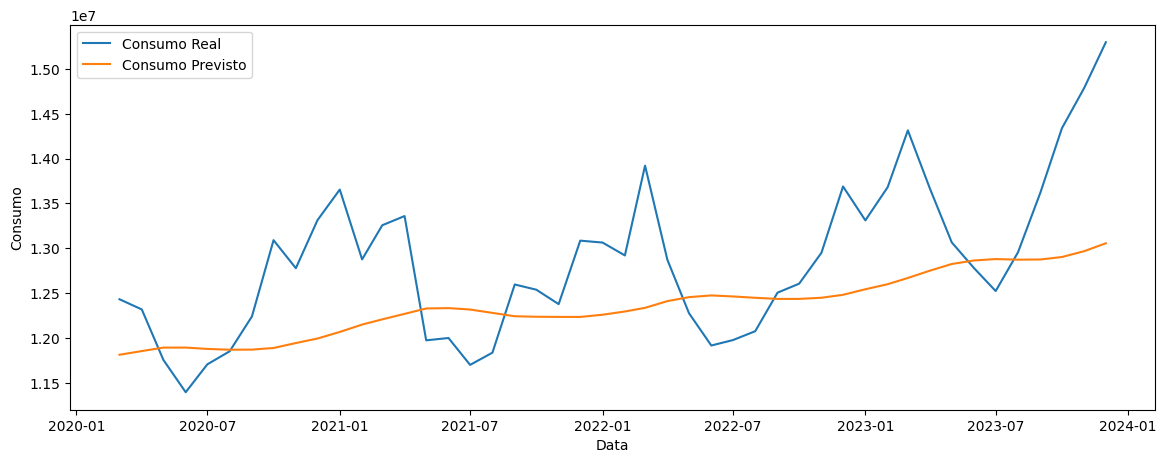

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_brasil['data'][train_size + n_steps:], y_test_inverted, label='Consumo Real')
plt.plot(df_brasil['data'][train_size + n_steps:], predictions_inverted, label='Consumo Previsto')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.legend()
plt.show()

6. Previsão para os Próximos 12 Meses

a. Use o modelo treinado para prever o consumo dos próximos 12 meses.

b. Plote um gráfico mostrando essas previsões.

In [ ]:
last_sequence = data[-n_steps:]

In [ ]:
future_predictions = []
future_dates = []

last_date = df_brasil['data'].iloc[-1]

for i in range(12):
    #formata a entrada para o modelo
    input_seq = last_sequence.reshape((1, n_steps, 2))
    #previsao
    next_pred = model.predict(input_seq)
    #adiciona previsao a lista
    future_predictions.append(next_pred[0][0])
    #atualiza a sequencia
    next_num_consumidores = last_sequence[-1, 1]
    next_input = np.array([next_pred[0][0], next_num_consumidores])
    last_sequence = np.vstack((last_sequence[1:], next_input))
    #atualizar as datas
    next_date = last_date + pd.DateOffset(months=1)
    future_dates.append(next_date)
    last_date = next_date


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
#desnormalizando as previsões

future_predictions_extended = np.concatenate((
    np.array(future_predictions).reshape(-1, 1),
    np.full((12, 1), last_sequence[-1, 1])
), axis=1)

future_predictions_inverted = scaler.inverse_transform(future_predictions_extended)[:, 0]

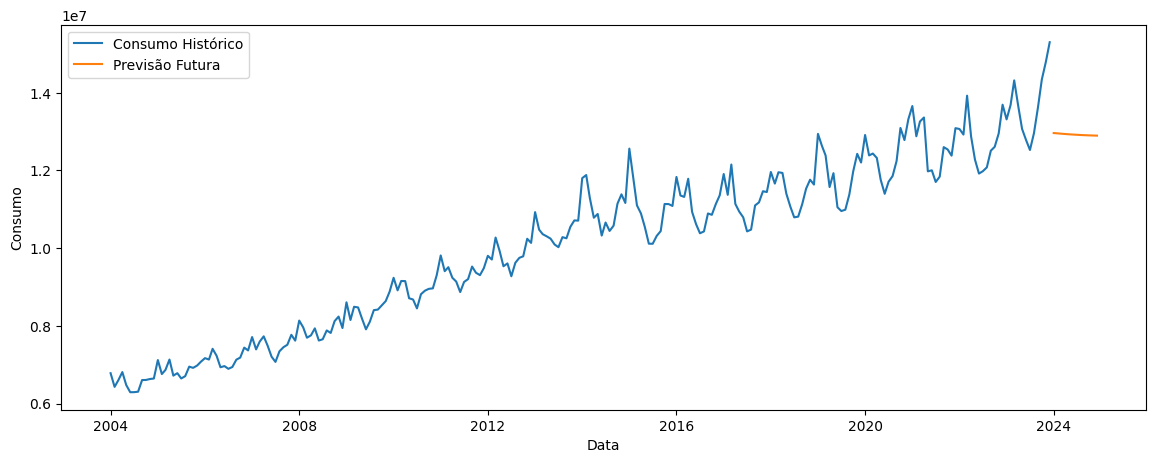

In [ ]:
#Previsao futura

historical_consumption = scaler.inverse_transform(df_brasil[['consumo', 'numero_consumidores']])[:, 0]

plt.figure(figsize=(14,5))
plt.plot(df_brasil['data'], historical_consumption, label='Consumo Histórico')
plt.plot(future_dates, future_predictions_inverted, label='Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.legend()
plt.show()


#7. Conclusão

##a. Análise dos Resultados

###**i. O modelo conseguiu capturar padrões no consumo de energia?**

O modelo LSTM utilizado apresentou dificuldade em capturar adequadamente os padrões sazonais e as flutuações mensais do consumo de energia elétrica residencial. Embora tenha conseguido identificar uma tendência média ao longo do tempo, ele falhou em reproduzir os picos e vales presentes nos dados históricos, o que indica uma limitação na capacidade do modelo de capturar a variação sazonal e a complexidade dos padrões de consumo.

###ii. O quão preciso foi o modelo?

A precisão do modelo foi baixa, com um erro quadrático médio (MSE) de aproximadamente 753 bi e uma raiz do erro quadrático médio (RMSE) de cerca de 867 mil. Esses valores elevados sugerem que as previsões estão significativamente distantes dos valores reais de consumo, reforçando que o modelo está subajustado para os dados. O comportamento linear nas previsões dos próximos 12 meses confirma que o modelo não conseguiu capturar adequadamente a sazonalidade e os picos característicos do consumo energético.

###iii. Sugestões de melhorias no modelo ou na preparação dos dados

**Ajuste de Hiperparâmetros**: Experimentar com uma quantidade maior de neurônios na camada LSTM, adicionar mais camadas LSTM e ajustar a taxa de Dropout podem ajudar o modelo a capturar melhor as variações nos dados.

**Incremento da Arquitetura do Modelo**: Explorar arquiteturas mais complexas, como a combinação de LSTM com camadas de atenção, ou até modelos baseados em Transformers, que podem capturar dependências temporais de maneira mais eficaz.

**Incorporação de Variáveis Externas**: Incluir dados adicionais, como variáveis climáticas ou econômicas, que podem influenciar o consumo de energia, ajudaria o modelo a entender melhor os fatores que causam as oscilações no consumo.

**Expansão do Conjunto de Dados**: Se possível, aumentar a quantidade de dados históricos para que o modelo tenha mais informações sobre padrões de longo prazo.

Essas melhorias poderiam aumentar a precisão do modelo e sua capacidade de prever com mais realismo o consumo energético futuro.